## Text Classification Using Logistic Regression, NaiveBayes and Random forest

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import os
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
plt.switch_backend('agg')
%matplotlib inline
import tensorflow as tf

C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\tensorflow\python\frame

## Load and Explore Data

In [2]:
TRAIN_PATH = os.path.join("C:/Users/annup", "bbc-text.csv")

In [3]:
bbc = pd.read_csv(TRAIN_PATH) # read the data

In [4]:
bbc.head() # read the first five rows

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
# Associate Category names with numerical index and save it in new column category_id
bbc['category_id'] = bbc['category'].factorize()[0]

#View first 10 entries of category_id, as a sanity check
bbc['category_id'][0:10]

0    0
1    1
2    2
3    2
4    3
5    4
6    4
7    2
8    2
9    3
Name: category_id, dtype: int64

In [6]:
# Create a new pandas dataframe "category_id_bbc", which only has unique Categories, also sorting this list in order of category_id values
category_id_bbc = bbc[['category', 'category_id']].drop_duplicates().sort_values('category_id')

In [7]:
category_id_bbc # create a new df with unique Category

,category,category_id
0,tech,0
1,business,1
2,sport,2
4,entertainment,3
5,politics,4


In [8]:
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category_id_bbc.values)
id_to_category = dict(category_id_bbc[['category_id', 'category']].values)

In [9]:
id_to_category

{0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [10]:
# Pick 5 random samples from the dataframe
bbc.sample(5, random_state=0)

,category,text,category_id
384,politics,drive to save festive holidays efforts are b...,4
1983,sport,officials respond in court row australian tenn...,2
985,sport,cup holders man utd visit everton holders manc...,2
1386,sport,adriano s chelsea link rejected adriano s agen...,2
1294,sport,o driscoll/gregan lead aid stars ireland s bri...,2


In [11]:
# Group the dataframe by categories and count items ( number of news articles) in each category
bbc.groupby('category').category_id.count()

category
business         510
entertainment    386
politics         417
sport            511
tech             401
Name: category_id, dtype: int64

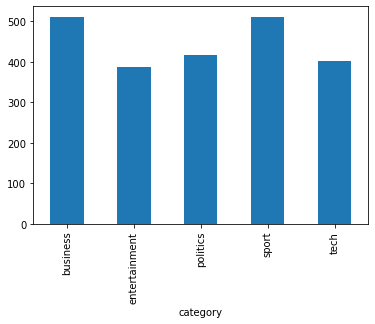

In [12]:
#Plot the distribution of news articles by category
bbc.groupby('category').category_id.count().plot.bar(ylim=0)

### Now we will convert news articles into numerical features using 'tfdif'

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(bbc.text).toarray() # Remaps the words in the 1490 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = bbc.category_id                           # represents the category of each of the 1490 articles


In [14]:
features.shape # How many features are there ? 

(2225, 14415)

In [15]:
# Remember the dictionary created to map category names to a number ? 
category_to_id.items()

dict_items([('tech', 0), ('business', 1), ('sport', 2), ('entertainment', 3), ('politics', 4)])

In [16]:
# The sorted function Converts dictionary items into a (sorted) list. 
# In subsequent steps - We will use this list to iterate over the categories
sorted(category_to_id.items())

[('business', 1),
 ('entertainment', 3),
 ('politics', 4),
 ('sport', 2),
 ('tech', 0)]

In [17]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
  indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
  feature_names = np.array(tfidf.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . oil
       . growth
       . shares
  . Most correlated bigrams:
       . analysts said
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . singer
       . actor
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . tony blair
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . coach
       . match
       . cup
  . Most correlated bigrams:
       . grand slam
       . australian open
       . champions league
# 'tech':
  . Most correlated unigrams:
       . technology
       . software
       . users
  . Most correlated bigrams:
       . anti virus
       . mobile phones
       . mobile phone


In [18]:
features_chi2

(array([0.00355164, 0.29252643, 0.67297617, ..., 0.02810703, 0.13112208,
        0.17836794]),
 array([0.95247768, 0.58860607, 0.4120159 , ..., 0.86685744, 0.71727145,
        0.67277957]))

##  Dimentionality Reduction

### We will use t-SNE and (t-Distributed Stochastc neighbor Embedding)

In [19]:
# t-Distributed Stochastc neighbor Embedding is used to keep similar instances close and dissimilar instances apart
from sklearn.manifold import TSNE

# Sampling a subset of our dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features)), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features[indices]) # Array of all projected features of 30% of Randomly chosen samples 

In [20]:
type(projected_features)

numpy.ndarray

In [21]:
my_id = 1 # Select a category_id
projected_features[(labels[indices] == my_id).values]

array([[ 17.081991 , -22.3272   ],
       [ 20.335342 , -30.455715 ],
       [  7.2913284, -29.916895 ],
       [ 12.139064 , -35.60774  ],
       [ 14.651095 , -33.959972 ],
       [ 30.014357 , -29.525265 ],
       [ 31.398586 , -24.53838  ],
       [ 14.985378 , -36.112053 ],
       [ 15.944437 , -40.089806 ],
       [ 13.52192  , -37.251328 ],
       [ 10.505769 , -35.312023 ],
       [ 18.438002 , -40.231304 ],
       [ 15.078821 , -18.272947 ],
       [  4.434383 ,  15.476416 ],
       [ 19.742271 , -35.101803 ],
       [ 12.216836 , -32.114998 ],
       [ 33.497143 ,   1.42356  ],
       [ 27.974787 , -33.07592  ],
       [ 23.794708 , -16.194464 ],
       [ 19.186563 , -27.559998 ],
       [ 12.867229 , -26.672781 ],
       [ 24.41072  , -31.904633 ],
       [ -2.4840152, -20.662405 ],
       [ 23.703531 , -34.25556  ],
       [ 30.510313 , -29.729826 ],
       [  7.9638524, -37.446606 ],
       [ 22.233294 , -34.972645 ],
       [  9.380408 , -31.121788 ],
       [ 18.639355 ,

#### Now plot the 2-dimentional distribution identified by t-SNE

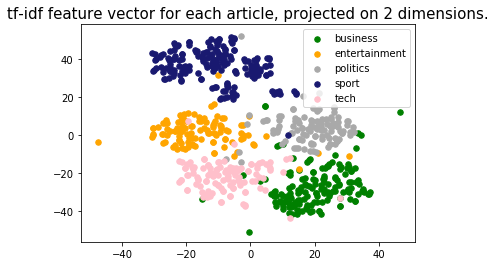

In [22]:
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']

# Find points belonging to each category and plot them
for category, category_id in sorted(category_to_id.items()):
    points = projected_features[(labels[indices] == category_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[category_id], label=category)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

## Model Training and Evaluation

### We will use 3 classification models on the data
 1-Logistic Regression,
 2- RandomForestClassifier
 3-MultinomialNB ( Naive Bayes)

In [23]:
features.shape

(2225, 14415)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

####  Now we will create a DataFrame that will store the results of various models
Each model will be run 5 times with different test sets of 30%

In [25]:
CV = 5  # Cross Validate with 5 different folds of 30% data ( 70-30 split with 5 folds )

#Create a data frame that will store the results for all 5 trials of the 3 different models
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = [] # Initially all entries are empty

#### Now we will run each Algorithm 5 times and store accuracy results in "entries"

In [26]:
#For each Algorithm 
for model in models:
  model_name = model.__class__.__name__
  # create 5 models with different 30% test sets, and store their accuracies
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  # Append all 5 accuracies into the entries list ( after all 3 models are run, there will be 3x5 = 15 entries)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\linea

#### Now staore the results in the results DataFrame

In [27]:
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

### Use seaborn to plot the results

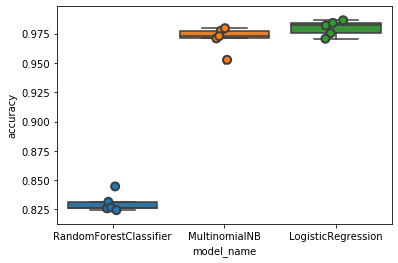

In [28]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

Here we can see that NaiveBayes and LogisticRegression are giving very good accuracy

In [29]:
# Mean accuracy of each algorithm
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.979782
MultinomialNB             0.970783
RandomForestClassifier    0.830570
Name: accuracy, dtype: float64

So now we will use LogisticRegression as our model

## Model fit Logistic regression with 30% of data randomly chosen for test

In [30]:
from sklearn.model_selection import train_test_split

model = LogisticRegression(random_state=0)

#Split Data 
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, bbc.index, test_size=0.30, random_state=0)

#Train Algorithm
model.fit(X_train, y_train)

# Make Predictions
y_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


## Print confusion matrix in test data using seaborn

Text(0.5, 15.0, 'Predicted')

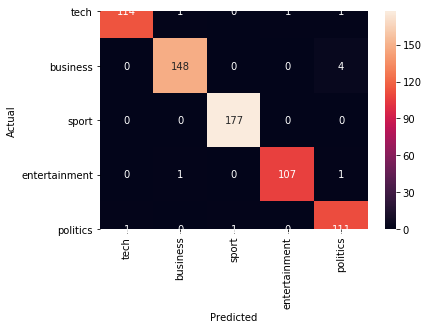

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_bbc.category.values, yticklabels=category_id_bbc.category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Study the failing scenarios
****Print the cases where article was miscategorised in same way at least 2 or more times

In [32]:
from IPython.display import display

for predicted in category_id_bbc.category_id:
  for actual in category_id_bbc.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 2:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(bbc.loc[indices_test[(y_test == actual) & (y_pred == predicted)]]['text'])
      print('')

'business' predicted as 'politics' : 4 examples.


1380    world leaders gather to face uncertainty more ...
2002    salary scandal in cameroon cameroon says wides...
2201    ban on forced retirement under 65 employers wi...
1702    call to overhaul uk state pension the uk pensi...
Name: text, dtype: object

## Finally we will use all the data to train the model

In [33]:
model.fit(features, labels)

C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\annup\Anaconda3\envs\py36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Print top 5 words / two-word combos for each Category

In [34]:
# model.coef_ contains the importance of each feature for each category
model.coef_

array([[ 1.14323215e-02,  1.73685328e-01,  1.01617199e-01, ...,
         9.63323652e-04, -3.72397714e-02, -3.59426129e-02],
       [-4.85576541e-02,  5.27776448e-01, -4.72771643e-02, ...,
         5.39620377e-02, -7.71544651e-03, -4.58535779e-02],
       [ 1.18352974e-02, -9.95879742e-01, -2.48636347e-02, ...,
         4.73254339e-02,  1.58555077e-01,  1.28367036e-01],
       [ 1.95630166e-02,  4.24918017e-01, -3.44306145e-02, ...,
        -9.62080875e-02, -8.20350726e-02, -4.47904639e-02],
       [ 8.93241927e-03,  1.94159452e-01,  5.89404153e-04, ...,
        -6.30931482e-03, -6.56059211e-02, -4.17406033e-02]])

In [35]:
from sklearn.feature_selection import chi2

N = 5
for category, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])   # This time using the model co-eficients / weights
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(category))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'business':
  . Top unigrams:
       . company
       . shares
       . bank
       . market
       . firm
  . Top bigrams:
       . chief executive
       . stock market
       . analysts said
       . economic growth
       . oil prices
# 'entertainment':
  . Top unigrams:
       . film
       . music
       . singer
       . tv
       . star
  . Top bigrams:
       . box office
       . los angeles
       . new york
       . film festival
       . big brother
# 'politics':
  . Top unigrams:
       . labour
       . party
       . mr
       . government
       . election
  . Top bigrams:
       . mr blair
       . tony blair
       . prime minister
       . general election
       . mr brown
# 'sport':
  . Top unigrams:
       . match
       . cup
       . club
       . win
       . game
  . Top bigrams:
       . year old
       . australian open
       . champions league
       . world number
       . bbc sport
# 'tech':
  . Top unigrams:
       . computer
       . users
       . 

In [36]:
texts = ["Hooli stock price soared after a dip in PiedPiper revenue growth.",
         "Captain Tsubasa scores a magnificent goal for the Japanese team.",
         "Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions.",
         "Beyoncé releases a new album, tops the charts in all of south-east Asia!",
         "You won't guess what the latest trend in data analysis is!"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"Hooli stock price soared after a dip in PiedPiper revenue growth."
  - Predicted as: 'business'

"Captain Tsubasa scores a magnificent goal for the Japanese team."
  - Predicted as: 'sport'

"Merryweather mercenaries are sent on another mission, as government oversight groups call for new sanctions."
  - Predicted as: 'politics'

"Beyoncé releases a new album, tops the charts in all of south-east Asia!"
  - Predicted as: 'entertainment'

"You won't guess what the latest trend in data analysis is!"
  - Predicted as: 'tech'

